# Loadings vs. Other Methods Mean/Median

### We want to see how the features' rating we arrive at with PCA > best silhouettes > average loading does with respect to the methods described in this paper:

[Some Structural Aspects of Language Are More Stable than Others: A Comparison of Seven Methods](http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0055009&type=printable)

### In particular, to check whether it predicts the median or average of measures listed in table 1 in the paper.

But the mean loading method is per - PC. If you look only at the loadings of PC1 or only at PC2 you find that this method is the worst predictor of the measures medians/means ( In [7] - In [12] ).

The best is P2 by Mikael Parkvall: [Which Parts of Language Are Most Stable?](http://www.academia.edu/26188604/Which_parts_of_language_are_the_most_stable)

### I don't see any edge for the PCA > silhouettes methods over other WALS stability computations in this respect.

In [1]:
from locator import *
from phonstats import agstats
from scipy.stats import pearsonr
import math
%matplotlib inline

### Load the Table from The Paper

In [2]:
dunn = pd.read_csv('../dunntable.csv')
dunn.replace(to_replace="–",value=np.nan,inplace=True)
dunn.set_index('walsid',inplace=True)
dunn.index = [c +'A' for c in dunn.index]
dunn.head()

,name,area,CM,CC,CR,D,P1,P2,W,M
1A,Consonant inventories,P,0.21,0.41,0.11,0.01,0.36,0.56,0.10,0.02
2A,Vowel quality inventories,P,0.43,0.79,0.75,0.50,0.65,0.38,0.48,0.40
3A,Consonant-vowel ratio,P,NaN,NaN,NaN,0.04,0.48,0.29,0.18,0.07
4A,Voicing in plosives and fricatives,P,0.75,0.55,0.44,0.22,0.22,0.49,0.24,0.15
5A,Voicing and gaps in plosive systems,P,0.68,0.82,0.88,NaN,0.16,0.43,0.38,0.43


### Load the Nominal Categories Features Rating by Mean Loading
as in  [the robustness notebook](https://github.com/ilay32/wals-project/blob/master/robustness.ipynb) for example

In [3]:
nomcats = pd.read_pickle('nominalcats-200.pkl')
# best 20 feature groups out of 68
good_by_average = [g for g in nomcats if g.pair_sils().mean() > 0.3]
loadings = agstats(good_by_average)

In [4]:
pc1 = loadings.loc['component 1']
pc1 = pc1[pc1.mean_loading.notnull() & (pc1.participation > 2)].sort_values(by='mean_loading',ascending=False)
pc1

,mean_loading,std,participation,subarea
features,,,,
31A,0.466678,0.0839198,7,None
32A,0.422809,0.082761,7,None
50A,0.413542,0.104499,7,None
30A,0.380163,0.0767466,7,None
49A,0.374743,0.0780295,7,None
51A,0.296423,0.243419,10,None
33A,0.108193,0.0971662,11,None
44A,0.0504757,0.0458076,3,None


In [5]:
rdunn = dunn.iloc[:,2:].loc[pc1.index]

### Create a Table That Lists the Various Stability Measures for Each of the Features in question

> For "mean loadings" it's the mean PC1 loading of every feature in the 20 good groups

In [6]:
df1 = pd.DataFrame(index=sorted(pc1.index),
                  columns=['mean_loadings','dunn_medians','dunn_means'])
df1['mean_loadings'] = pc1['mean_loading']
df1['dunn_medians'] = [rdunn.loc[c].dropna().astype(float).median() for c in df1.index]
df1['dunn_means'] = [rdunn.loc[c].dropna().astype(float).mean() for c in df1.index]
df1 = pd.concat((df1,rdunn),axis=1)
df1

,mean_loadings,dunn_medians,dunn_means,CM,CC,CR,D,P1,P2,W,M
30A,0.380163,0.755,0.707500,0.84,0.64,0.18,0.56,0.67,0.92,0.99,0.86
31A,0.466678,0.890,0.857143,0.88,0.74,0.50,NaN,0.89,0.99,1.00,1.00
32A,0.422809,0.840,0.772857,0.84,0.72,0.27,NaN,0.80,0.97,0.95,0.86
33A,0.108193,0.630,0.564286,0.69,0.53,0.12,NaN,0.76,0.80,0.63,0.42
44A,0.0504757,0.750,0.745000,0.64,0.91,0.74,0.49,0.80,0.88,0.76,0.74
49A,0.374743,0.265,0.351250,0.97,0.24,0.08,0.03,0.29,0.51,0.60,0.09
50A,0.413542,0.395,0.458750,0.94,0.45,0.32,0.09,0.21,0.59,0.73,0.34
51A,0.296423,0.600,0.677143,0.95,0.53,0.56,NaN,0.57,0.82,0.71,0.60


### plot every Measure in the article table against the table mean/median. 

> every plot and every computation is done only on the measures that have a  value for the given feature.

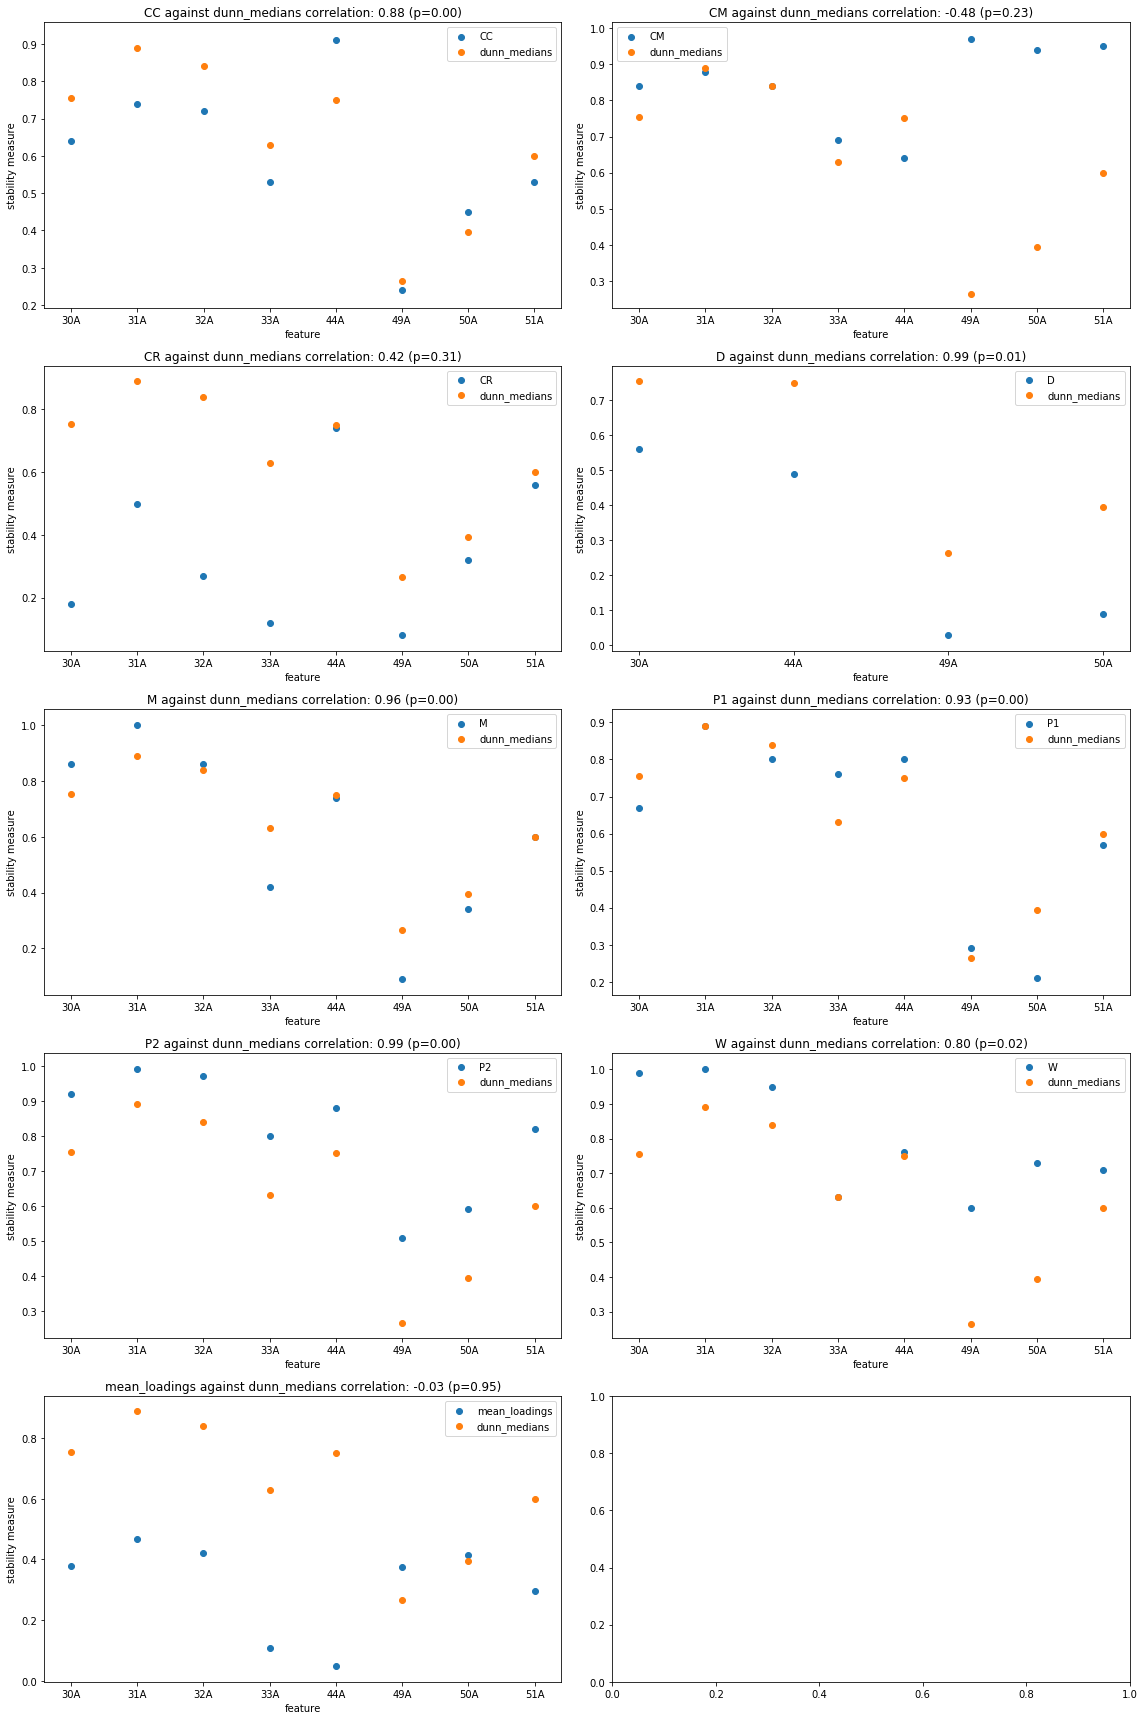

In [7]:
def plot_against(c,d):
    ms = d.columns.difference(pd.Index(['dunn_medians','dunn_means']))
    fig,axes = plt.subplots(figsize=(16,24),nrows=math.ceil((len(d.columns) -1)/2),ncols=2)
    for ax,m in zip(axes.flatten(),ms):
        corrinds = d[m].dropna().index.intersection(d[c].dropna().index)
        x = np.arange(len(corrinds))
        ax.set_xticks(x)
        ax.set_xticklabels(corrinds)
        corr = pearsonr(d.loc[corrinds][m].astype(float),d.loc[corrinds][c].astype(float))
        ax.set_title('{:s} against {:s} correlation: {:.2f} (p={:.2f})'.format(m,c,*corr))
        ax.set_xlabel('feature')
        ax.set_ylabel('stability measure')
        ax.scatter(x,d.loc[corrinds][m],label=m)
        ax.scatter(x,d.loc[corrinds][c],label=c)
        ax.legend()
        plt.tight_layout()
    plt.show()
plot_against('dunn_medians',df1)

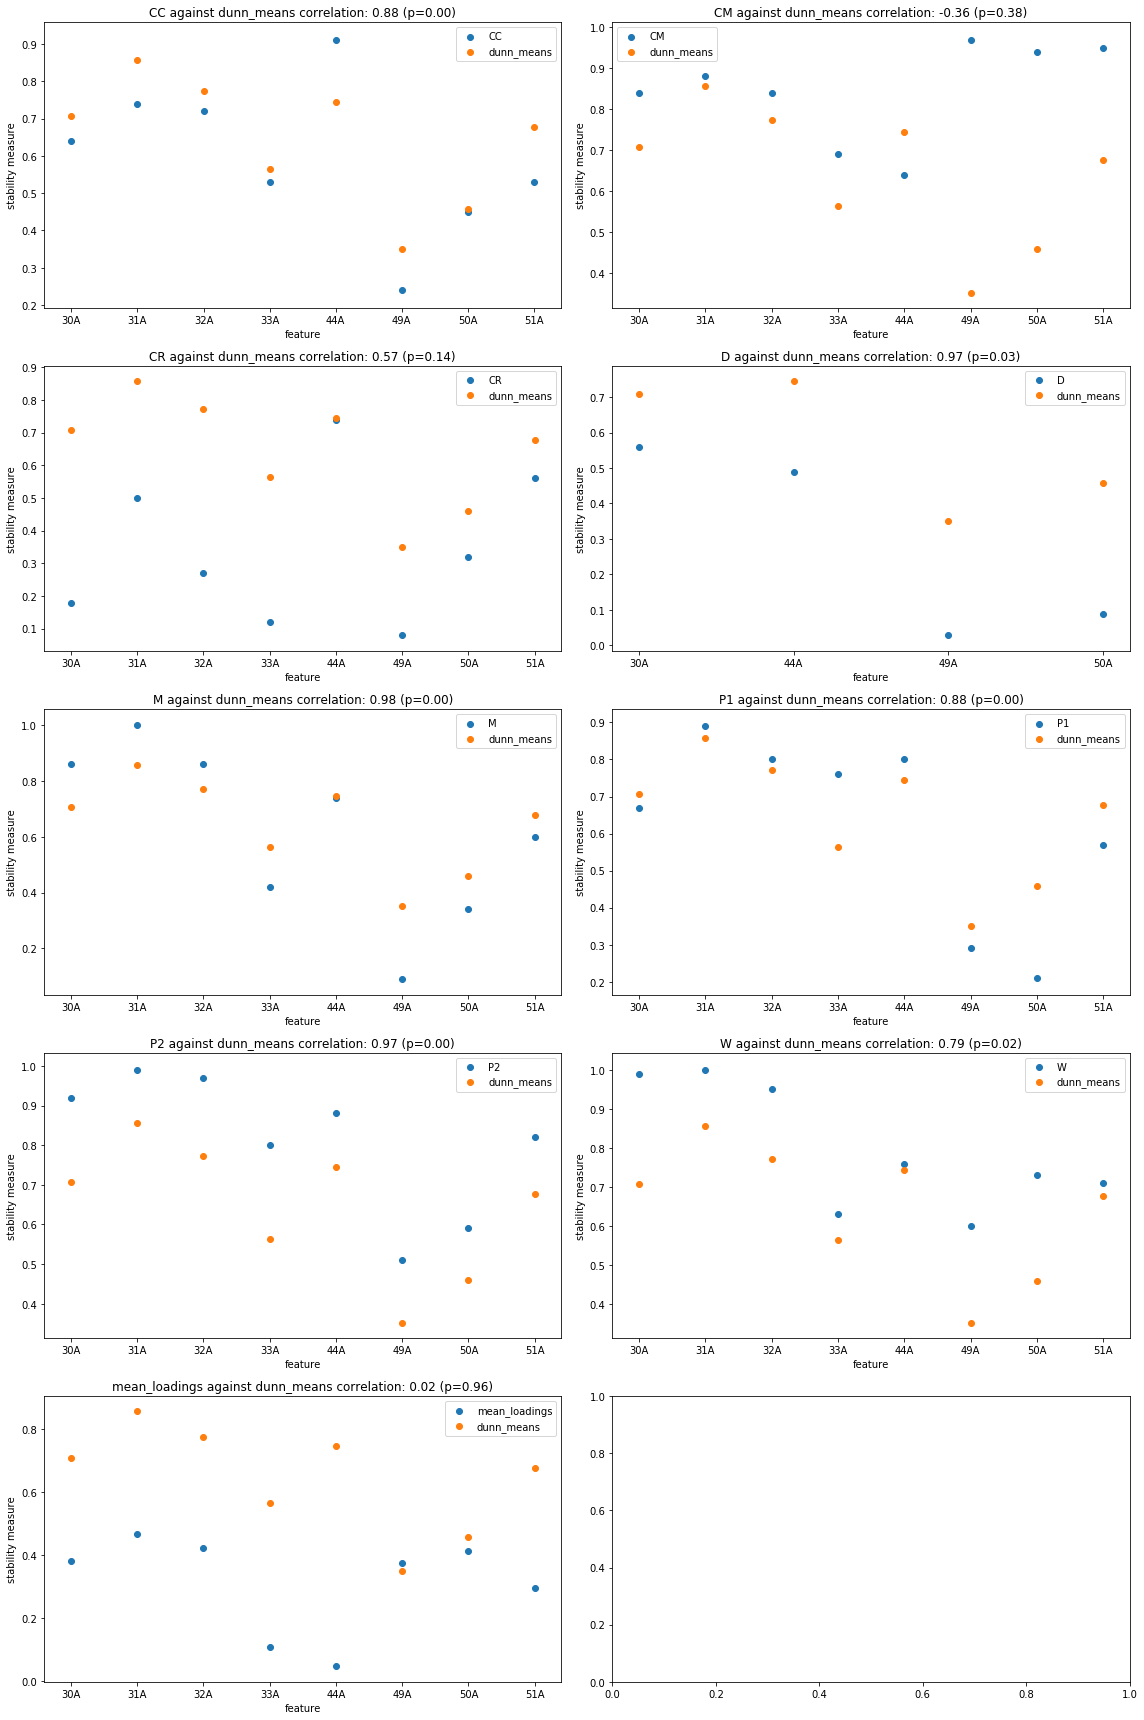

In [9]:
plot_against('dunn_means',df1)

### Same for PC2

In [10]:
pc2 = loadings.loc['component 2']
pc2 = pc2[pc2.mean_loading.notnull() & (pc2.participation > 2)].sort_values(by='mean_loading',ascending=False)
df2 = pd.DataFrame(index=sorted(pc2.index),
                  columns=['mean_loadings','dunn_medians','dunn_means'])
df2['mean_loadings'] = pc2['mean_loading']
df2['dunn_medians'] = [rdunn.loc[c].dropna().astype(float).median() for c in df2.index]
df2['dunn_means'] = [rdunn.loc[c].dropna().astype(float).mean() for c in df2.index]
df2 = pd.concat((df2,rdunn),axis=1)

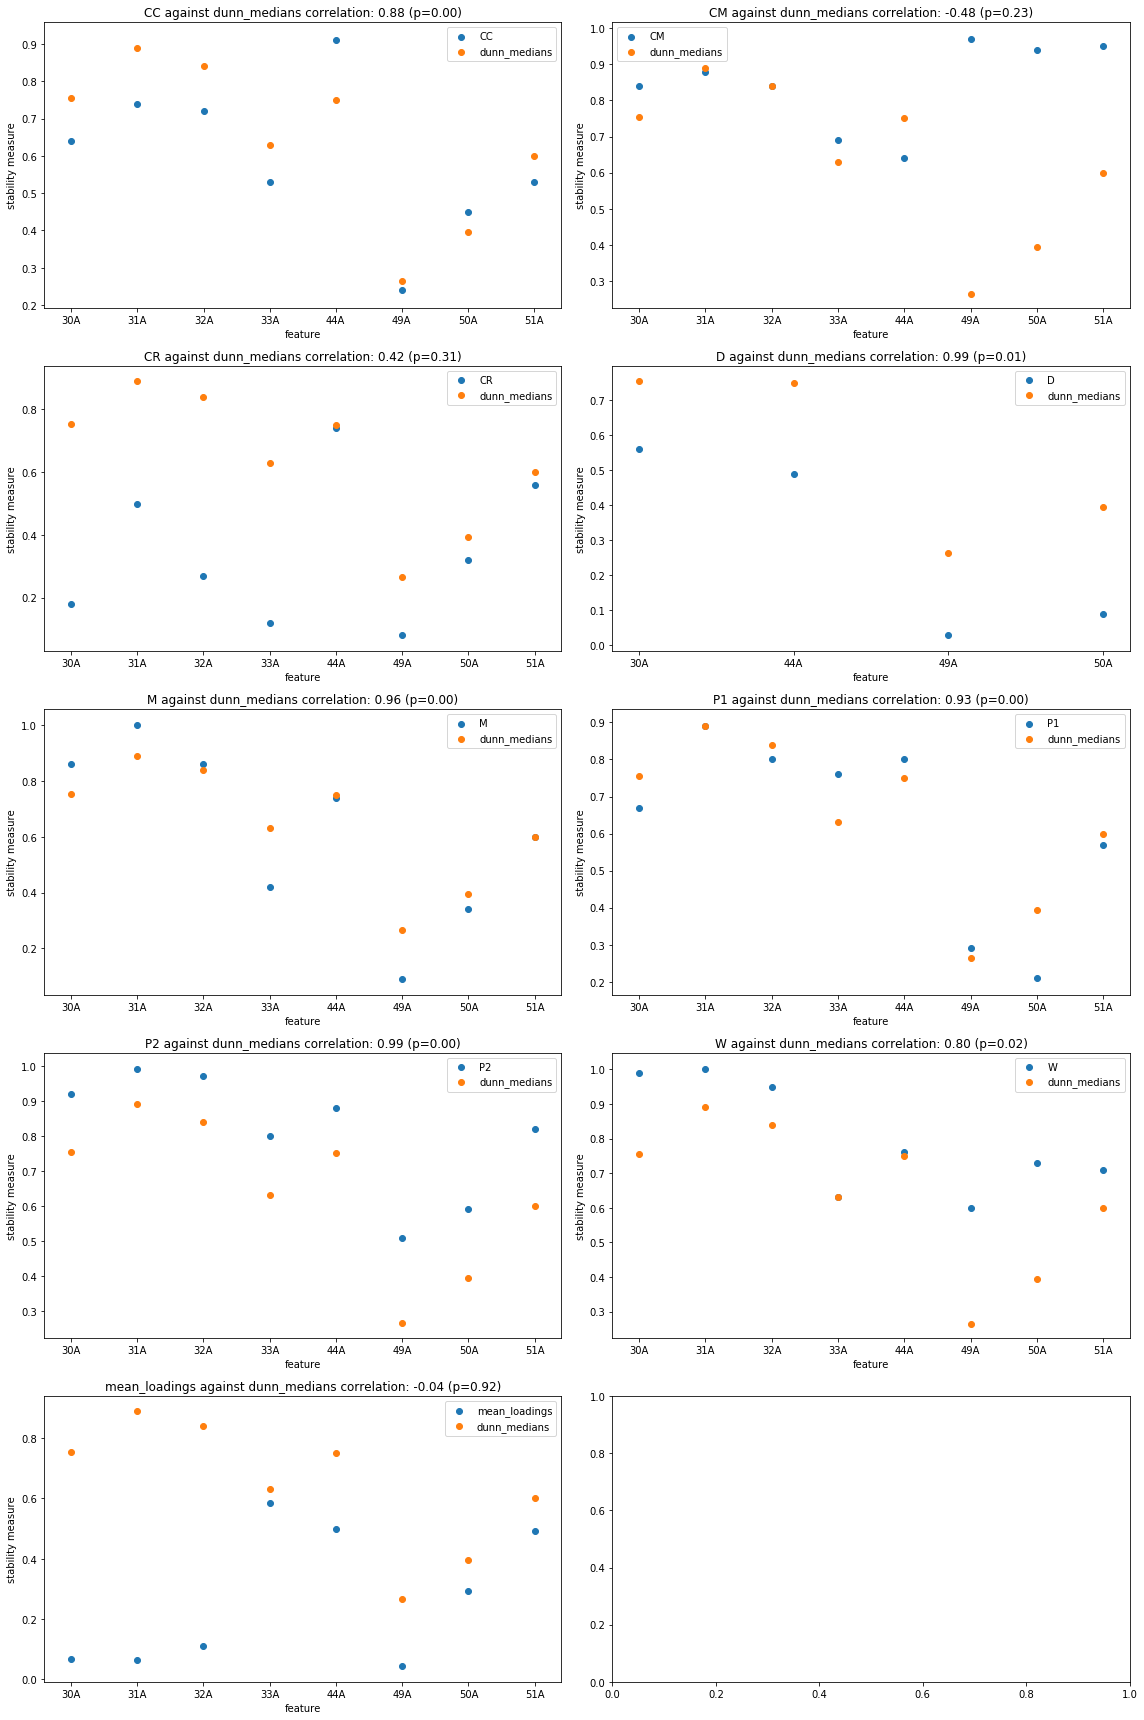

In [11]:
plot_against('dunn_medians',df2)

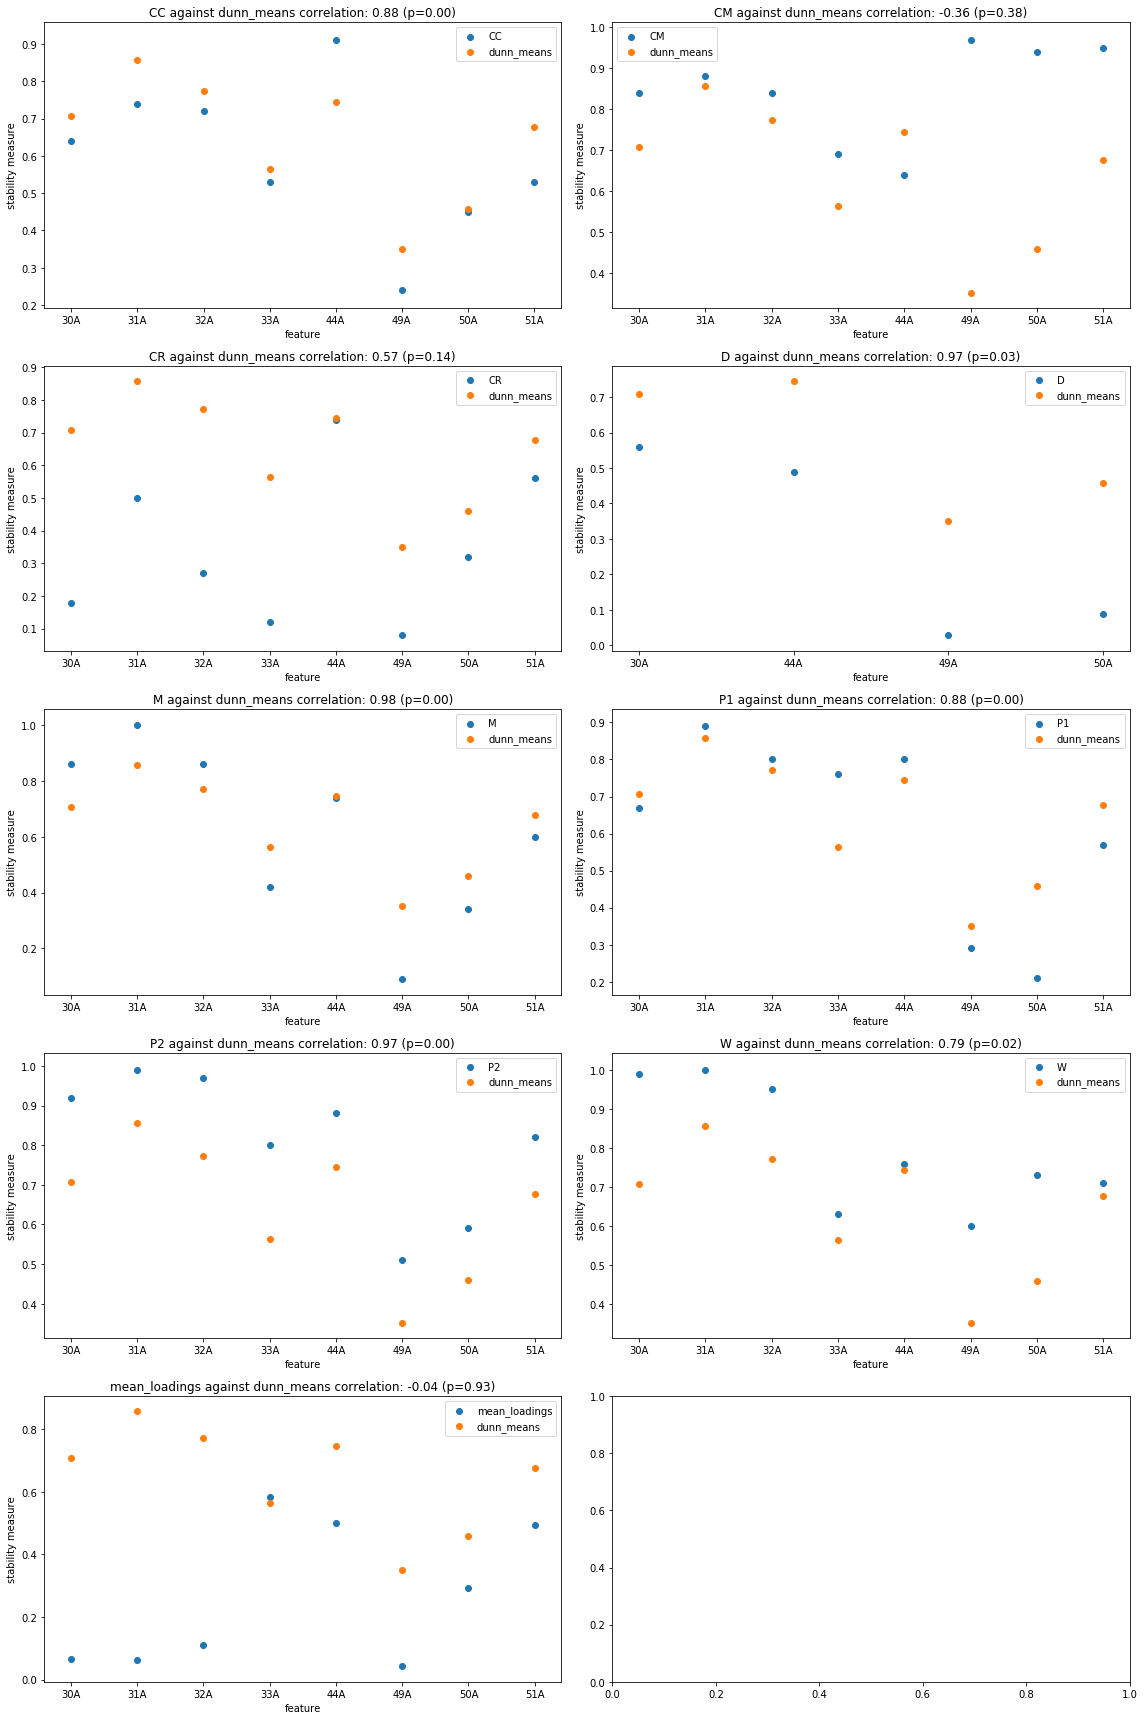

In [12]:
plot_against('dunn_means',df2)

In [13]:
pearsonr(df1['dunn_medians'],df1['dunn_means'])

(0.97216984098469528, 5.2768870149074336e-05)